In [130]:
import geopandas
import momepy
import networkx as nx
import shapely
from shapely.geometry import Point
import pandas as pd
import esda.shape as shape
import matplotlib.pyplot as plt
import numpy as np

helper functions

In [131]:
### from https://github.com/martinfleis/urban-block-artifacts/blob/main/code/02_measure.ipynb

def get_polygon_gdf(roads):

    # Polygonize street network
    polygons = geopandas.GeoSeries(
        shapely.polygonize(  # polygonize
            shapely.node(  # ensure properly nodded non-planar interesections
                shapely.GeometryCollection(  # need a single geometry for nodding
                    roads.geometry.array
                )
            ).geoms  # get parts of the collection from nodding
        ).geoms,  # get parts of the collection from polygonize
        crs=roads.crs,
    ).explode(
        ignore_index=True
    )  # shoudln't be needed but doesn't hurt to ensure

    # Store geometries as a GeoDataFrame
    polygons = geopandas.GeoDataFrame(geometry=polygons)

    # Ensure all polygons are valid. Should not be necessary.
    if not polygons.is_valid.all():
        polygons = geopandas.GeoDataFrame(
            geometry=geopandas.GeoSeries(
                shapely.make_valid(polygons.geometry.array), crs=roads.crs
            ).explode(ignore_index=True)
        )

    # Ensure that all geometries are polygons
    if not (polygons.geom_type == "Polygon").all():
        polygons = polygons[polygons.geom_type == "Polygon"].reset_index(drop=True)

    area = polygons.area

    # measure (circular) compactness
    polygons["circular_compactness"] = shape.minimum_bounding_circle_ratio(polygons)
    polygons["circular_compactness_index"] = polygons["circular_compactness"] * area

    # isoperimetric_quotient
    polygons["isoperimetric_quotient"] = shape.isoperimetric_quotient(polygons)
    polygons["isoperimetric_quotient_index"] = polygons["isoperimetric_quotient"] * area

    # isoareal_quotient
    polygons["isoareal_quotient"] = shape.isoareal_quotient(polygons)
    polygons["isoareal_quotient_index"] = polygons["isoareal_quotient"] * area

    # radii_ratio
    polygons["radii_ratio"] = shape.radii_ratio(polygons)
    polygons["radii_ratio_index"] = polygons["radii_ratio"] * area

    # diameter_ratio
    polygons["diameter_ratio"] = shape.diameter_ratio(polygons)
    polygons["diameter_ratio_index"] = polygons["diameter_ratio"] * area

    # from https://github.com/pysal/momepy/blob/main/momepy/preprocessing.py#L1561-L1773
    polygons["face_artifact_index"] = np.log(
        shape.minimum_bounding_circle_ratio(polygons) * polygons.area
    )

    return polygons


load data

In [132]:
# convert to nx object;
# count comps in processed data (should be 25)
gdf = geopandas.read_file("../data/raw/edges_final.gpkg")
G = momepy.gdf_to_nx(gdf)
comps = [c for c in nx.connected_components(G)]
comps = sorted(comps,key=len, reverse=True) # sort comps by descending length
assert len(comps)==25

get polygon gdf

In [133]:
polygons = get_polygon_gdf(gdf)

/Users/jqz304/miniconda3/envs/bikenwloops/lib/python3.12/site-packages/shapely/constructive.py:1353: RuntimeWarning: divide by zero encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/jqz304/miniconda3/envs/bikenwloops/lib/python3.12/site-packages/shapely/constructive.py:1353: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


number of artifacts to still get rid of (=polygons with face artifact index below 7)

In [134]:
len(polygons[polygons.face_artifact_index<7])

509

save to file to check in qgis and plot these artifacts (with a bufffer)

In [136]:
polygons[polygons.face_artifact_index < 7].to_file("../data/raw/poly_fai_below_7.gpkg", index=False)

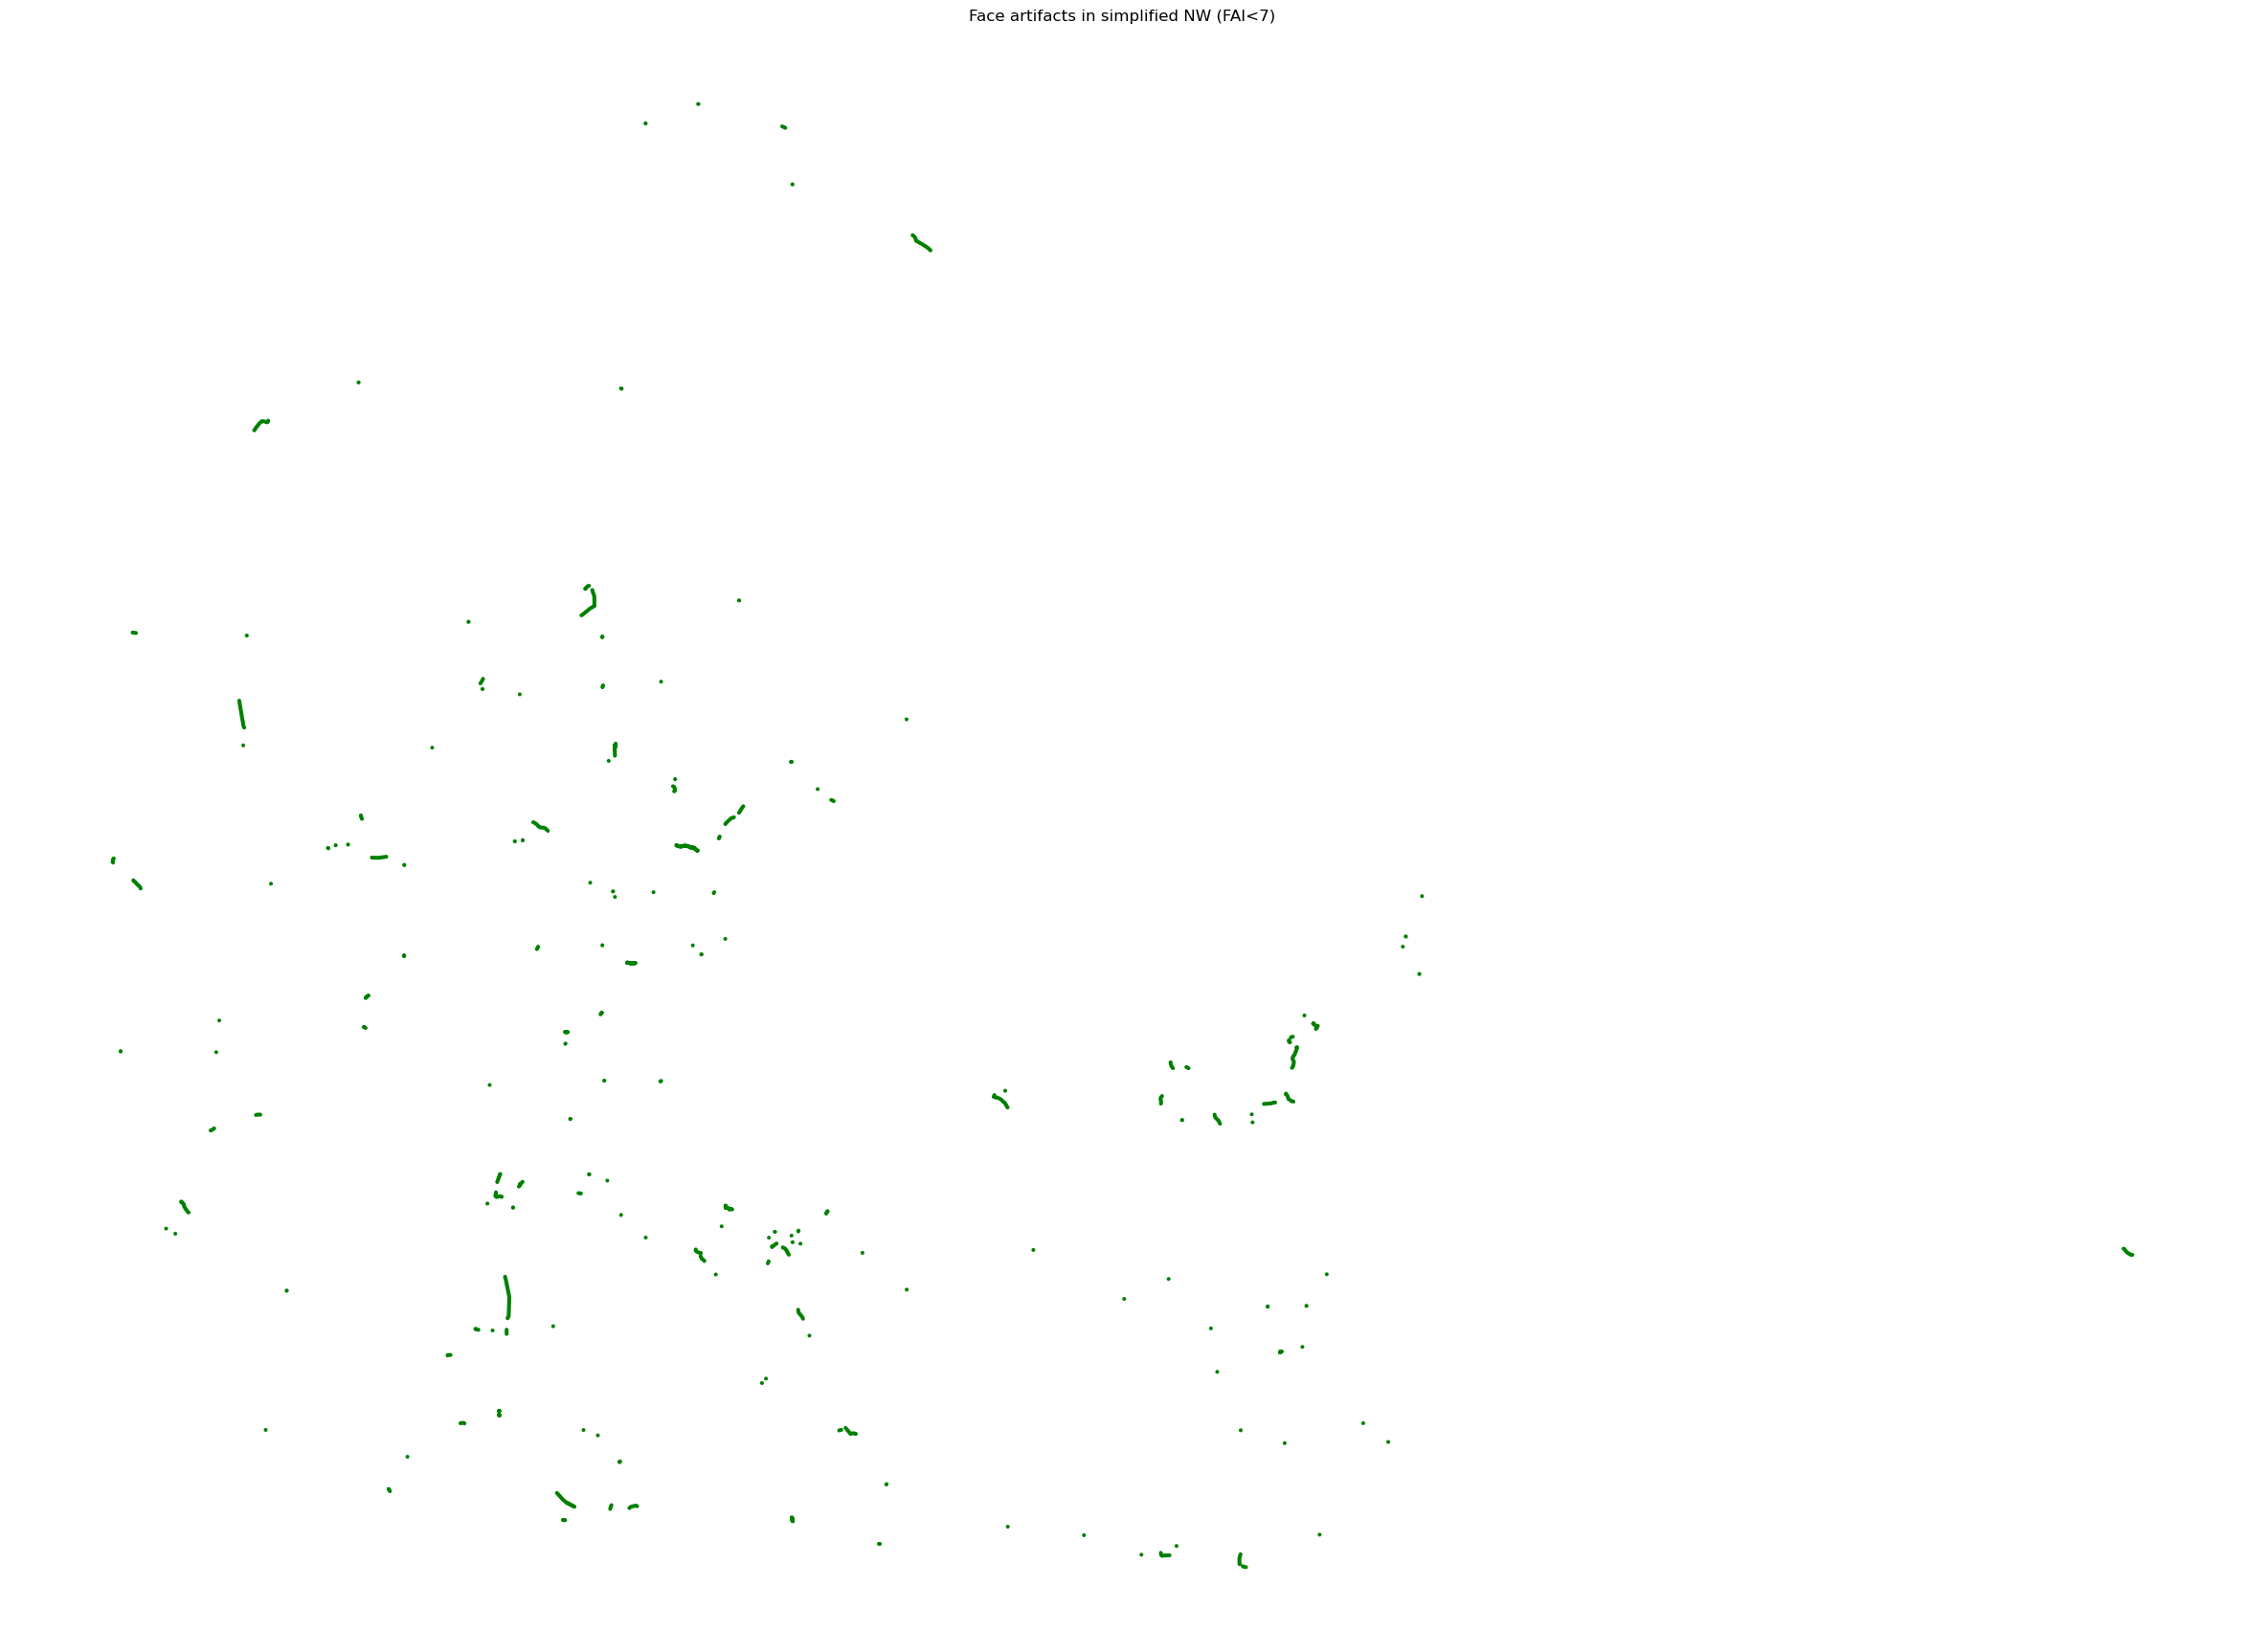

In [137]:
fig, ax = plt.subplots(1,1, figsize=(30,30))
polygons[polygons.face_artifact_index<7].geometry.buffer(400).plot(ax=ax, color="green")
ax.set_title("Face artifacts in simplified NW (FAI<7)")
ax.set_axis_off()

***

Can we manually remove those by dropping parallel edges?

In [138]:
proj_crs = "EPSG:25832"

In [139]:
# create edge_collect and node_collect gdfs
# edge_collect... contains edges and component IDs
# edge_collect will be used to pass on to neatnet comp-wise
# node_collect... only for plotting

edge_collect = []
node_collect = []

for i, comp in enumerate(comps):
        
        S = G.subgraph(comp)

        # collect all edges compwise in one gdf
        edgedata = list(S.edges(data=True))
        gdf_comp = geopandas.GeoDataFrame(
            {
                "geometry": [edge[2]["geometry"] for edge in edgedata],
                "orig": [edge[0] for edge in edgedata],
                "dest": [edge[1] for edge in edgedata]
            },
            crs = proj_crs
        )
        gdf_comp["comp"] = i
        edge_collect.append(gdf_comp)

        # collect all nodes compwise in one gdf
        nodedata = list(S.nodes(data=False))
        gdf_nodes = geopandas.GeoDataFrame(
            {
                "geometry": [Point(n) for n in nodedata]
            },
            crs = proj_crs
        )
        gdf_nodes["comp"] = i
        node_collect.append(gdf_nodes)

edge_collect = pd.concat(edge_collect).reset_index(drop=True)
edge_collect = geopandas.GeoDataFrame(edge_collect, crs = proj_crs)

node_collect = pd.concat(node_collect).reset_index(drop=True)
node_collect = geopandas.GeoDataFrame(node_collect).reset_index(drop=True)

make gdf of face artifacts to remove

In [140]:
fais = polygons[polygons.face_artifact_index<7].copy().reset_index(drop=True)

***

## potential reason for neatnet failures:

missing nodes (see example of face artifact with index 10 below) >> additional noding needed pre-neatnet?

In [142]:
i = 10

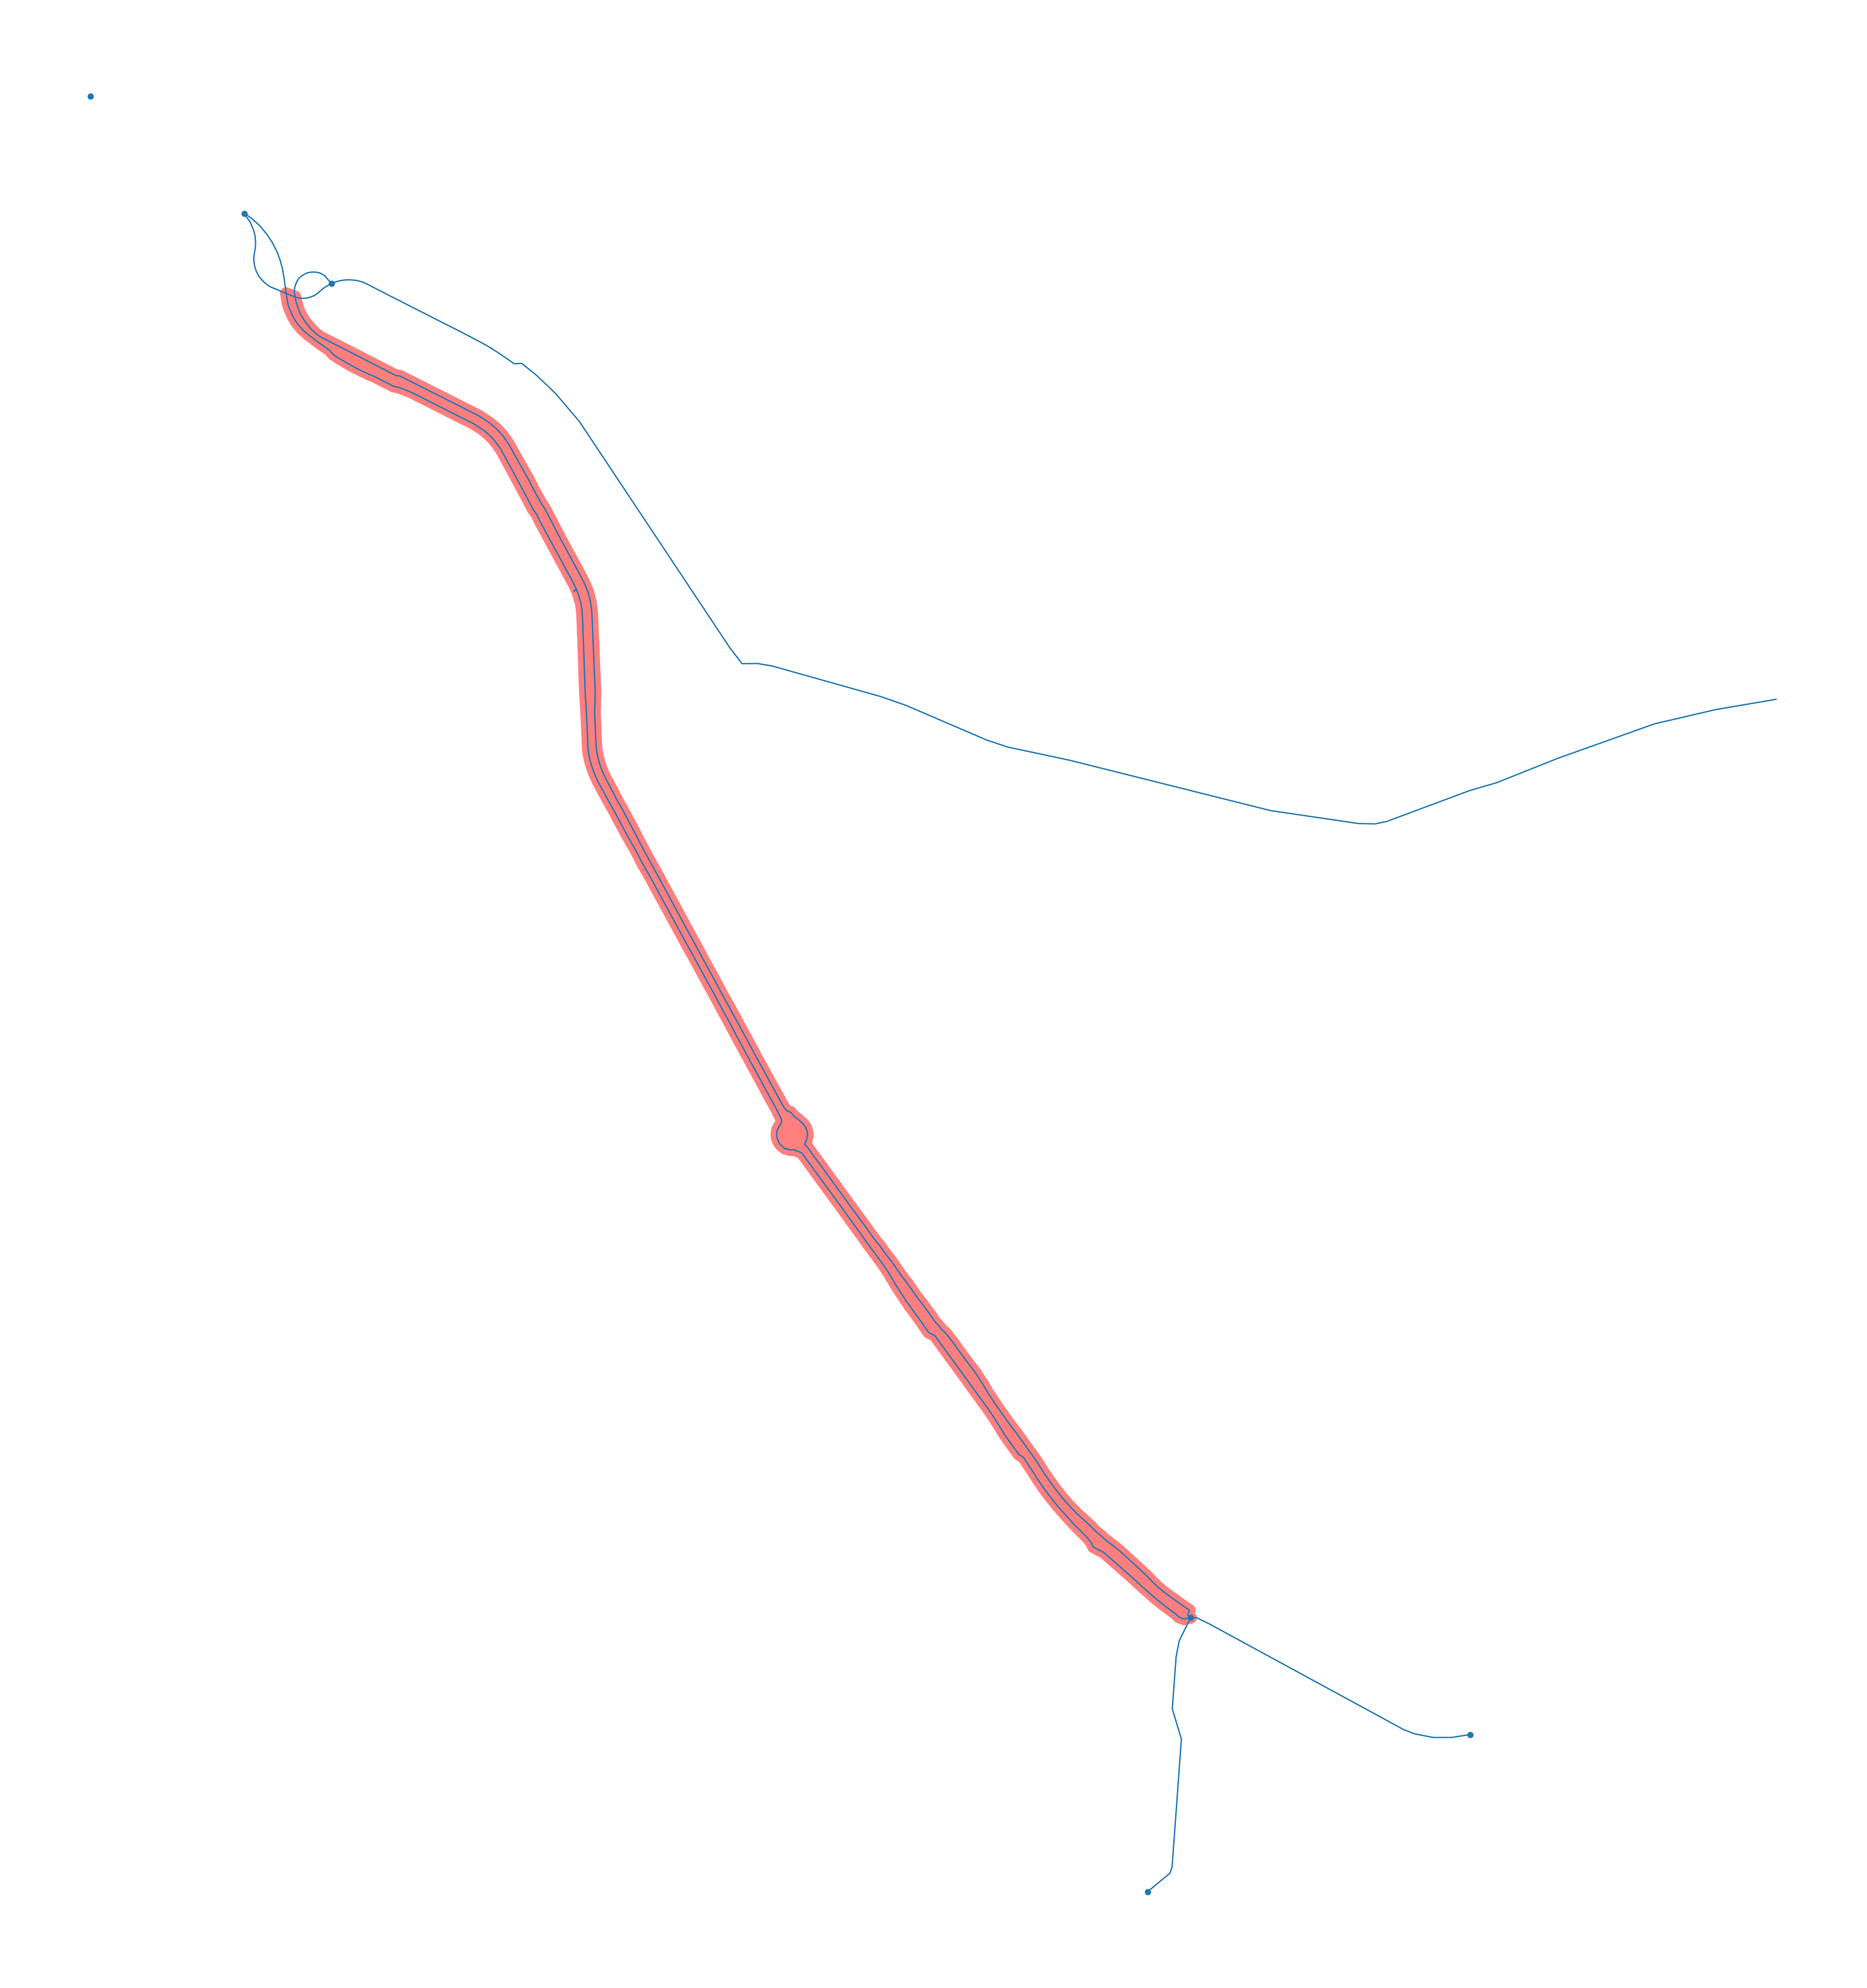

In [143]:
polycoords = [z for z in zip(geopandas.GeoSeries(fais.loc[i,"geometry"]).get_coordinates().x, geopandas.GeoSeries(fais.loc[i,"geometry"]).get_coordinates().y)]
polynodes = [c for c in polycoords if c in G.nodes]
fig, ax = plt.subplots(1,1, figsize = (40,40))
fais.filter([i], axis=0).buffer(10).plot(ax=ax, color="red", alpha=0.5)
#edge_collect[(edge_collect.orig.isin(polynodes))|(edge_collect.dest.isin(polynodes))].plot(ax=ax, cmap="turbo")
node_collect[node_collect.intersects(fais.loc[i,"geometry"].buffer(1000))].plot(ax=ax)
edge_collect[edge_collect.intersects(fais.loc[i,"geometry"].buffer(100))].plot(ax=ax)
ax.set_axis_off()
plt.show()